In [1]:
import pandas as pd
import numpy as np
import os

import torch

from utils import get_path

user_df = pd.read_csv(get_path('user.csv'))
load_df = pd.read_csv(get_path('load.csv'))
server_df = pd.read_csv(get_path('server.csv'))
service_df = pd.read_csv(get_path('service.csv'))
inv_df = pd.read_csv(get_path('invocation.csv'))

In [27]:
inv_df[(inv_df['uid'] == 280) & (inv_df['eid'] == 532) & (inv_df['sid'] == 135) & (inv_df['timestamp'] == 267)]

,uid,eid,sid,timestamp,rt,original_order
16830949,280,532,135,267,1.251801,16830949
16830950,280,532,135,267,1.251801,16830950
16830971,280,532,135,267,1.251801,16830971
16830976,280,532,135,267,1.251801,16830976
16830978,280,532,135,267,1.251801,16830978
16830989,280,532,135,267,1.251801,16830989
16830994,280,532,135,267,1.251801,16830994


In [28]:
user_df[(user_df['画id'] == 280) & (user_df['timestamp'] == 267)]

,id,timestamp,lon,lat,speed,direction,tot
267622,280,267,121.337942,31.258022,17.3,141.0,66


In [29]:
load_df[(load_df['eid'] == 532) & (load_df['timestamp'] == 267)]

,timestamp,eid,computing_load,storage_load,bandwidth_load
471253,267,532,87.15%,65.30%,39.48%


In [30]:
server_df[server_df['eid'] == 532]

,eid,lon,lat,radius,computing,storage,bandwidth
532,532,121.340352,31.260888,707,4,1,6


In [ ]:
df

In [ ]:
t_df = pd.merge(left=load_df, right=server_df, left_on='eid', right_on='eid').reset_index(drop=True)
t_df = t_df[['timestamp', 'eid', 'computing', 'storage', 'bandwidth']]
service_df = pd.read_csv(get_path('service.csv'))
temp_df = pd.merge(inv_df, service_df, left_on='sid', right_on='sid').reset_index(drop=True)
t_df = pd.merge(t_df, temp_df, left_on=['timestamp', 'eid'], right_on=['timestamp', 'eid'], how='left',
              suffixes=('_server', '_service')).reset_index(drop=True)
t_df = t_df[['timestamp', 'eid', 'computing_server', 'storage_server', 'bandwidth_server', 'computing_service',
         'storage_service', 'bandwidth_service']]
t_df = t_df.groupby(['timestamp', 'eid', 'computing_server', 'storage_server', 'bandwidth_server']).agg(
    {'computing_service': 'sum', 'storage_service': 'sum', 'bandwidth_service': 'sum'}).sort_values(
    by='timestamp').reset_index()

In [ ]:
t_df

In [ ]:
d = dict()

ts = t_df['timestamp'].values
e_ids = t_df['eid'].values
tot_c = t_df['computing_service'].values
tot_s = t_df['storage_service'].values
tot_b = t_df['bandwidth_service'].values

for i in range(len(ts)):
    d[(e_ids[i], ts[i])] = (tot_c[i], tot_s[i], tot_b[i])

In [ ]:
d[(1300, 0)]

In [ ]:
x = np.random.randint(300, 1001, len(server_df))

In [3]:
from utils import find_servers
from tqdm import tqdm
import numpy as np

def generate_graph(user_df, server_df):
    t_eid = server_df['eid'].values
    t_lat = server_df['lat'].values
    t_lon = server_df['lon'].values
    t_radius = server_df['radius'].values
    edges = [[False for _ in range(len(server_df))] for _ in range(len(server_df))]

    # 将 user_df 转为列表形式，减少访问开销
    user_data = user_df.groupby('uid').apply(lambda g: g.sort_values(by='timestamp')[['lat', 'lon']].values).to_dict()

    for uid, rows in tqdm(user_data.items()):
        pre = []
        for lat, lon in rows:
            eids = find_servers(lat, lon, t_eid, t_lat, t_lon, t_radius)
            for i in range(len(eids)):
                for j in range(i + 1, len(eids)):
                    edges[eids[i]][eids[j]] = True
                    edges[eids[j]][eids[i]] = True
            for x in pre:
                for y in eids:
                    edges[x][y] = True
                    edges[y][x] = True
            pre = eids

    edge_index = []
    for i in range(len(server_df)):
        for j in range(len(server_df)):
            if edges[i][j]:
                edge_index.append([i, j])

    return np.array(edge_index).T

ModuleNotFoundError: No module named 'utils'

In [ ]:
x = generate_graph(user_df, server_df)

In [ ]:
x.shape

In [ ]:
df = pd.DataFrame(x.T, columns=['source', 'target'])

In [ ]:
df.to_csv(get_path('edges.csv'), index=False)

In [42]:
server_c, server_s, server_b = 4, 1, 6
rate_c,  rate_s, rate_b = 0.8715, 0.6530, 0.3948
service_c, service_s, service_b = 6, 2, 6
tot_c, tot_s, tot_b = 516, 462, 517

In [43]:
e_rated = [16, 64, 128, 512, 1024, 2048]
s_rated = [1, 8, 64, 512, 2048, 4096]

up_transmission = s_rated[service_b - 1] / (service_b / tot_b * (1.0 - rate_b) * e_rated[server_b - 1] * 128)
down_transmission = s_rated[service_b - 1] / ((1.0 - rate_b) * e_rated[server_b - 1] * 128)

print(f'up_transmission: { up_transmission }')
print(f'down_transmission: { down_transmission }')

up_transmission: 2.2246433685833886
down_transmission: 0.025817911434236618


In [44]:
import math

lam_c = service_c / tot_c
mu_c = lam_c * (server_c * (1 - rate_c) + 1)
c_queue = lam_c / (mu_c * (mu_c - lam_c))

lam_s = service_s / tot_s
mu_s = lam_s * (server_s * (1 - rate_s) + 1)
s_queue = lam_s / (mu_s * (mu_s - lam_s))

lam_b = service_b / tot_b
mu_b = lam_b * (server_b * (1 - rate_b) + 1)
b_queue = lam_b / (mu_b * (mu_b - lam_b))

p_c = server_c * (1 - rate_c) / service_c
p_s = server_s * (1 - rate_s) / service_s
p_b = server_b * (1 - rate_b) / service_b

c_queue *= math.exp(-p_c)
s_queue *= math.exp(-p_s)
b_queue *= math.exp(-p_b)

print(f'c_queue: { c_queue }')
print(f's_queue: { s_queue }')
print(f'b_queue: { b_queue }')

c_queue: 101.43898534230853
s_queue: 415.4940574922489
b_queue: 2.7974386183023148


In [45]:
process_c = service_c / ((1 - rate_c) * server_c) * (1 + rate_c)
process_s = service_s / ((1 - rate_s) * server_s) * (1 + rate_s)

In [46]:
print(f'process_c: { process_c }')
print(f'process_s: { process_s }')

process_c: 21.846303501945535
process_s: 9.527377521613834


In [47]:
up_transmission + down_transmission + c_queue + s_queue + b_queue + process_c + process_s

553.3546237564367

In [48]:
x = np.log(2 + up_transmission) + np.log(2 + c_queue) + np.log(2 + s_queue) + np.log(b_queue) + process_c + process_s + down_transmission

In [49]:
x_min, x_max = -3.894103616034186, 152.1034567987616

In [50]:
def normalize_to_range(values: np.ndarray, a=0, b=1) -> np.ndarray:
    normalized_values = (values - x_min) / (x_max - x_min) * (b - a) + a
    return normalized_values

In [51]:
from utils import haversine, update_user_position

u_lat, u_lon = 31.258022, 121.337942
e_lat, e_lon = 31.260888, 121.340352
u_speed, u_direction = 17.3, 141

req = haversine(u_lat, u_lon, e_lat, e_lon) / 3e8
n_lat, n_lon = update_user_position(u_lat, u_lon, u_speed, u_direction, req * 1000 + (np.tanh(normalize_to_range(x, -3, 2.3)) + 1) * 10)
rep = haversine(n_lat, n_lon, e_lat, e_lon) / 3e8
print(f'req: { req }')
print(f'imit: { x }')
print(f'rep: { rep }')

req: 1.308246461866558e-06
imit: 44.54239023768608
rep: 1.3290602130017746e-06


In [52]:
req * 1000 + (np.tanh(normalize_to_range(x, -3, 2.3)) + 1) * 10 + rep * 1000

1.251816460857512

In [7]:
g = inv_df.groupby(['uid', 'timestamp']).size().reset_index(name='count')

In [8]:
x = g[(g['uid'] == 77)]['count'].tolist()

In [19]:
import plotly.graph_objects as go

fig = go.Figure()

# 添加折线
fig.add_trace(go.Scatter(x=np.arange(0, len(x)), y=x, mode='lines', name='折线'))

# 设置图表标题和标签
fig.update_layout(
    title='折线图示例',
    xaxis_title='X 轴',
    yaxis_title='Y 轴',
    showlegend=True
)

# 显示图表
fig.show()

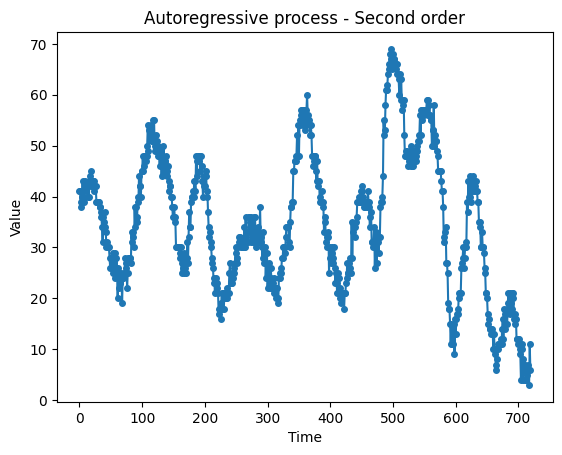

In [9]:
from matplotlib import pyplot as plt

plt.plot(np.arange(0, len(x)), x, marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Autoregressive process - Second order');